# Debt Market Model

The purpose of this notebook is to configure and simulate the full CDP and APT system model, using a stochastic Ethereum price and liquidity demand process as a driver, under different PI controller settings - enabled, disabled, `kp` and `ki`.

# Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/georgekellerman/github/reflexer/venv/lib/python3.8/site-packages
Requires: fn, pandas, funcy, pathos
Required-by: cadCAD-machine-search
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import all shared dependencies and setup
from shared import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

# Environmental Processes

In [3]:
# Import the ETH price stochastic dataset
from models.system_model_v3.model.params.init import eth_price_df

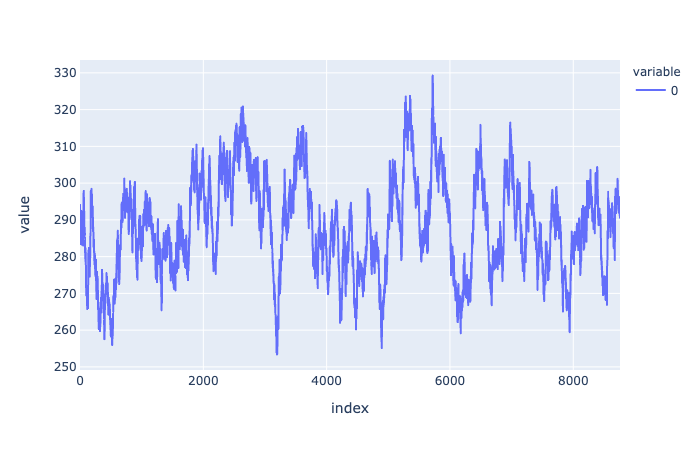

In [4]:
# Plot the ETH price for the first MC run dataset
eth_price_df['0'].plot()

# Model Configuration

In [5]:
from models.system_model_v3.model.state_variables.init import state_variables

state_variables.update({})

In [6]:
from models.system_model_v3.model.params.init import params

# Update the default parameter values
params_update = {
    'controller_enabled': [True],
    'kp': [2e-07], # proportional term for the stability controller: units 1/USD
    'ki': [-5e-9], # integral term for the stability controller: units 1/(USD*seconds)
}

params.update(params_update)

# Simulation Execution

In [7]:
# Set the number of simulation timesteps, with a maximum of `len(eth_price_df) - 1`
SIMULATION_TIMESTEPS = len(eth_price_df) - 1
SIMULATION_TIMESTEPS# = 3000

8758

In [8]:
# Create a wrapper for the model simulation, and update the existing parameters and initial state
system_simulation = ConfigWrapper(system_model_v3, T=range(SIMULATION_TIMESTEPS), M=params, initial_state=state_variables)

In [9]:
del configs[:] # Clear any prior configs
(simulation_result, _tensor_field, _sessions) = run(system_simulation, drop_midsteps=False) # Run the simulation


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (8758, 38, 1, 51)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
rate trader selling       APY=-38.47, RAI_delta=5914.93, ETH_delta=-63.58, market_price=3.15, redemption_price=3.14
rate trader selling       APY=-38.47, RAI_delta=2939.78, ETH_delta=-31.73, market_price=3.14, redemption_price=3.14
rate trader selling       APY=-38.47, RAI_delta=30973.82, ETH_delta=-336.57, market_price=3.18, redemption_price=3.14
rate trader selling       APY=-38.47, RAI_delta=3934.02, ETH_delta=-42.44, market_price=3.14, redemption_price=3.14
rate trader selling       APY=-26.97, RAI_delta=5893.91, ETH_delt

# Simulation Analysis

In [10]:
# Add new columns to dataframe
simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

#simulation_result

## Save simulation

In [11]:
# Save the simulation result to a pickle file, for backup - this will be overwritten on the next simulation
simulation_result.to_pickle(f'./exports/system_model_v3/results.pickle')

# Simulation Analysis

In [12]:
# Load the simulation result from a pickle file, specifying past results when necessary
simulation_result = pd.read_pickle(f'exports/system_model_v3/results.pickle')

# Drop the simulation midsteps - the substeps that aren't used for generating plots
df = drop_dataframe_midsteps(simulation_result)
#df

## Select simulation

In [13]:
# Select the first simulation and subset, this is only relevant when running parameter sweeps or Monte Carlo Runs
# The following plots are configured for single simulation results
df = df.query('simulation == 0 and subset == 0')

## Check trader profits

In [14]:
price_trader_start = df.iloc[0]['price_trader_usd_balance'] + \
                     df.iloc[0]['price_trader_rai_balance'] * df.iloc[0]['market_price']
price_trader_end = df.iloc[-1]['price_trader_usd_balance'] + \
                     df.iloc[-1]['price_trader_rai_balance'] * df.iloc[-1]['market_price']
price_trader_profit = price_trader_end  - price_trader_start

neg_rate_trader_start = df.iloc[0]['neg_rate_trader_usd_balance'] + \
                     df.iloc[0]['neg_rate_trader_rai_balance'] * df.iloc[0]['market_price']
neg_rate_trader_end = df.iloc[-1]['neg_rate_trader_usd_balance'] + \
                     df.iloc[-1]['neg_rate_trader_rai_balance'] * df.iloc[-1]['market_price']
neg_rate_trader_profit = neg_rate_trader_end  - neg_rate_trader_start

pos_rate_trader_start = df.iloc[0]['pos_rate_trader_usd_balance'] + \
                     df.iloc[0]['pos_rate_trader_rai_balance'] * df.iloc[0]['market_price']
pos_rate_trader_end = df.iloc[-1]['pos_rate_trader_usd_balance'] + \
                     df.iloc[-1]['pos_rate_trader_rai_balance'] * df.iloc[-1]['market_price']
pos_rate_trader_profit = pos_rate_trader_end  - pos_rate_trader_start

rate_trader_start = df.iloc[0]['rate_trader_usd_balance'] + \
                     df.iloc[0]['rate_trader_rai_balance'] * df.iloc[0]['market_price']
rate_trader_end = df.iloc[-1]['rate_trader_usd_balance'] + \
                     df.iloc[-1]['rate_trader_rai_balance'] * df.iloc[-1]['market_price']
rate_trader_profit = rate_trader_end  - rate_trader_start

print(f"{price_trader_profit=}")
print(f"{neg_rate_trader_profit=}")
print(f"{pos_rate_trader_profit=}")
print(f"{rate_trader_profit=}")

price_trader_profit=-2395369.1841900945
neg_rate_trader_profit=0.0
pos_rate_trader_profit=0.0
rate_trader_profit=9137978.475061774


df.plot(x='timestamp', y=['market_price', 'market_price_twap'])

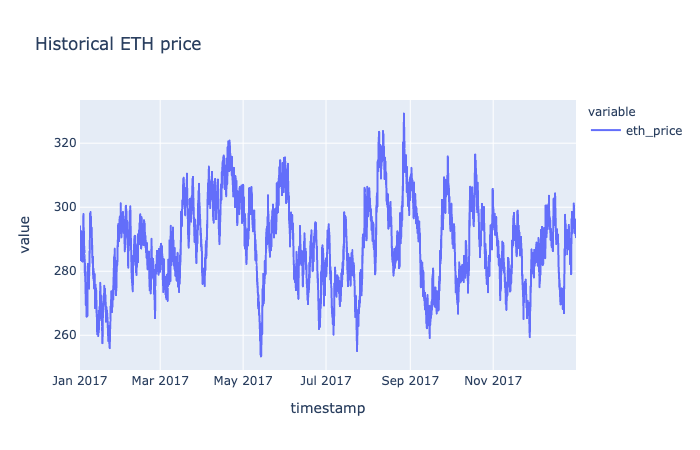

In [15]:
df.plot(x='timestamp', y=['eth_price'], title='Historical ETH price')

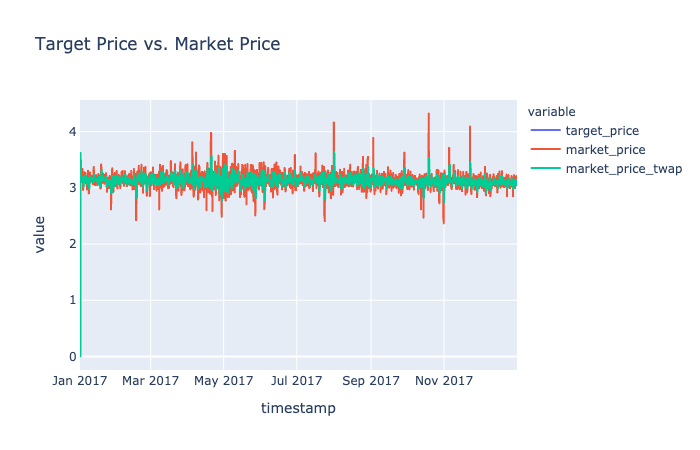

In [16]:
df.plot(x='timestamp', y=['target_price', 'market_price', 'market_price_twap'], title='Target Price vs. Market Price')

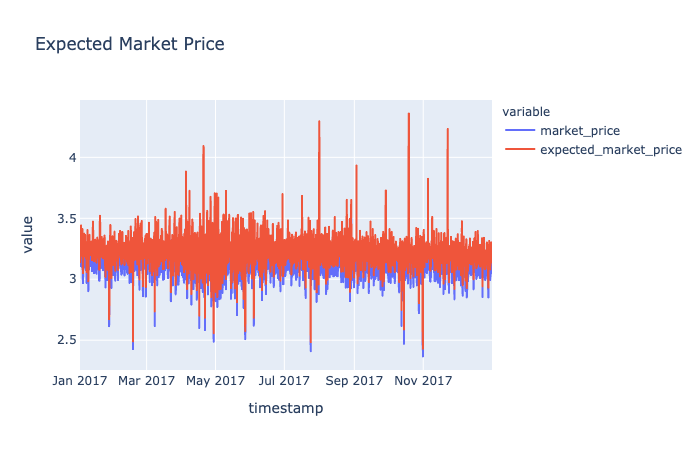

In [17]:
df.plot(x='timestamp', y=['market_price', 'expected_market_price'], title='Expected Market Price')

In [38]:
df['apy'] = 1 - (1 + df['target_rate'])**(60*60*24*365) * 100

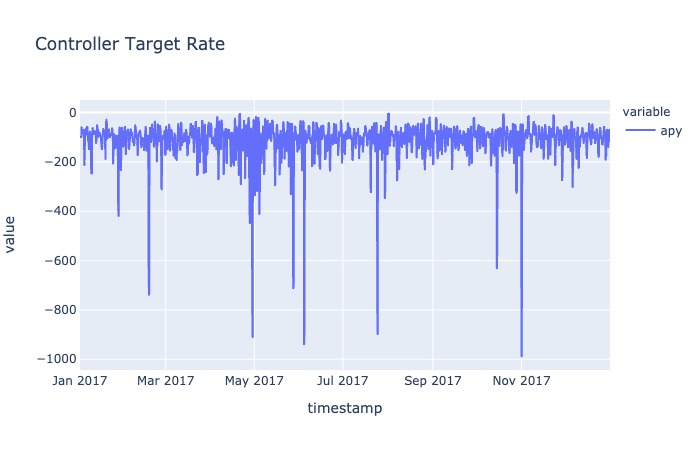

In [39]:
df.plot(x='timestamp', y=['apy'], title='Controller Target Rate')

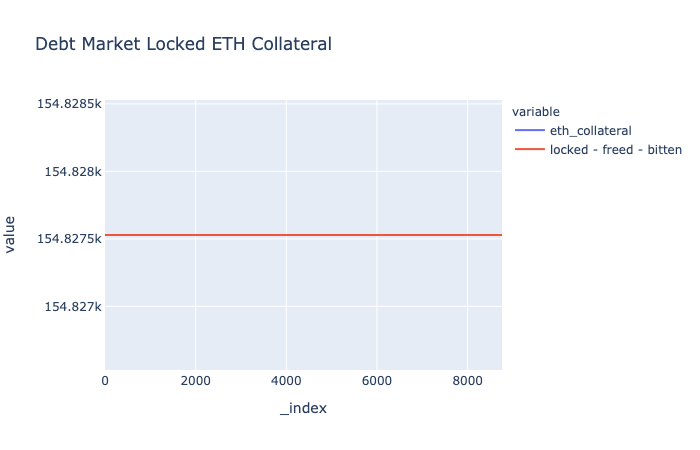

In [19]:
df['locked - freed - bitten'] = df['eth_locked'] - df['eth_freed'] - df['eth_bitten']
df.plot(y=['eth_collateral', 'locked - freed - bitten'], title='Debt Market Locked ETH Collateral')

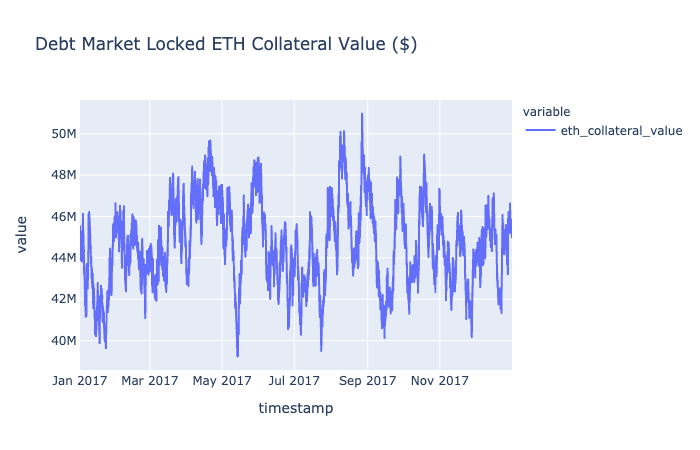

In [20]:
df.plot(x='timestamp', y=['eth_collateral_value'], title='Debt Market Locked ETH Collateral Value ($)')

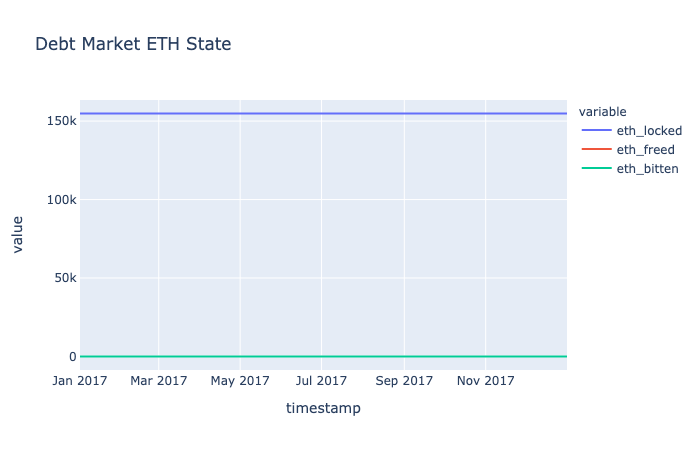

In [21]:
df.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'], title='Debt Market ETH State')

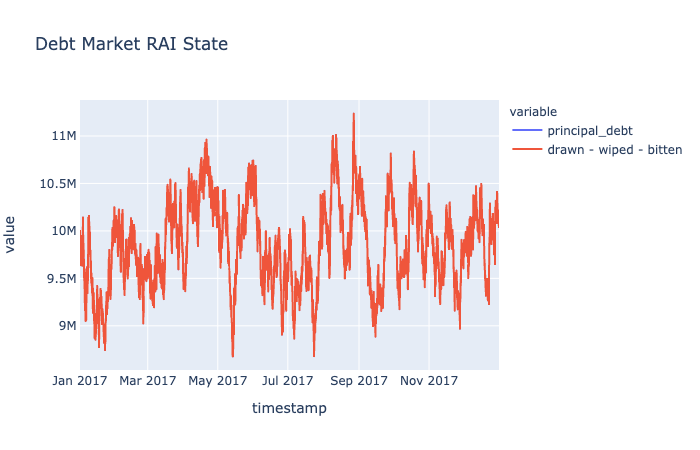

In [22]:
df['drawn - wiped - bitten'] = df['rai_drawn'] - df['rai_wiped'] - df['rai_bitten']
df.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten'], title='Debt Market RAI State')

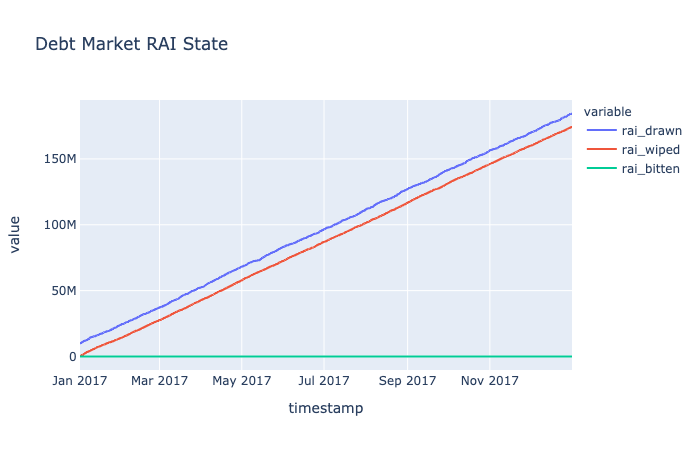

In [23]:
df.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'], title='Debt Market RAI State')

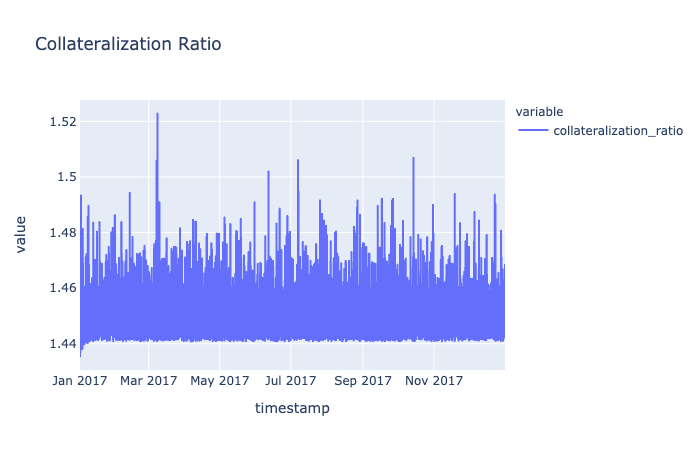

In [24]:
df.plot(x='timestamp', y=['collateralization_ratio'], title='Collateralization Ratio')

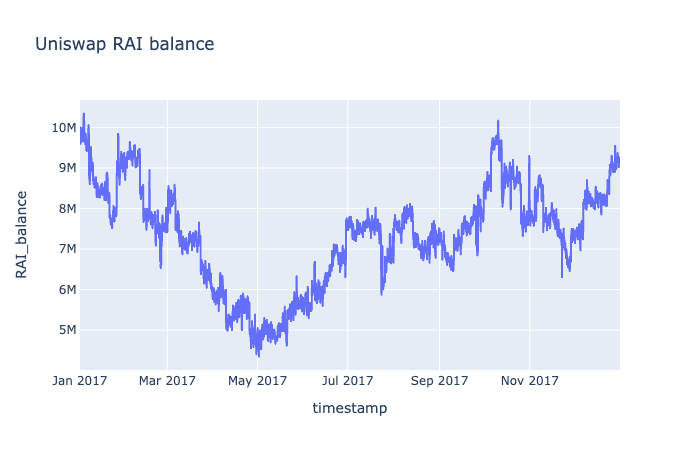

In [25]:
df.plot(x='timestamp', y='RAI_balance', title='Uniswap RAI balance')

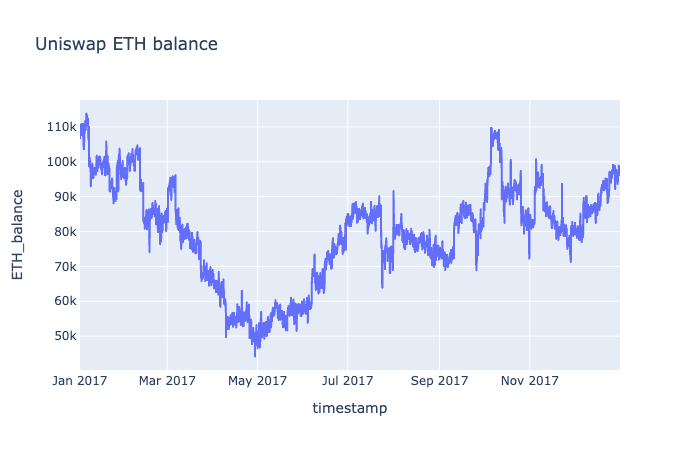

In [26]:
df.plot(x='timestamp', y='ETH_balance', title='Uniswap ETH balance')

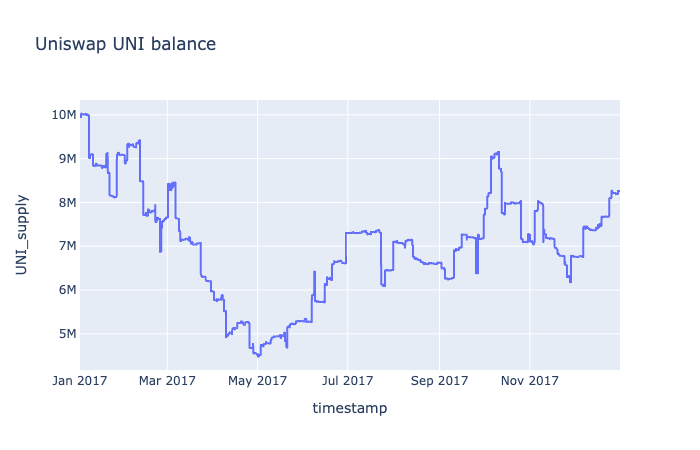

In [27]:
df.plot(x='timestamp', y='UNI_supply', title='Uniswap UNI balance')

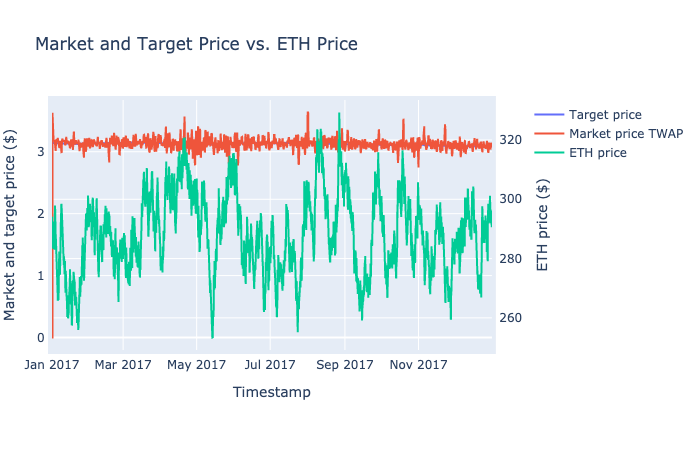

In [28]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Target price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price_twap'], name="Market price TWAP"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['eth_price'], name="ETH price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Market and Target Price vs. ETH Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Market and target price ($)", secondary_y=False)
fig.update_yaxes(title_text="ETH price ($)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

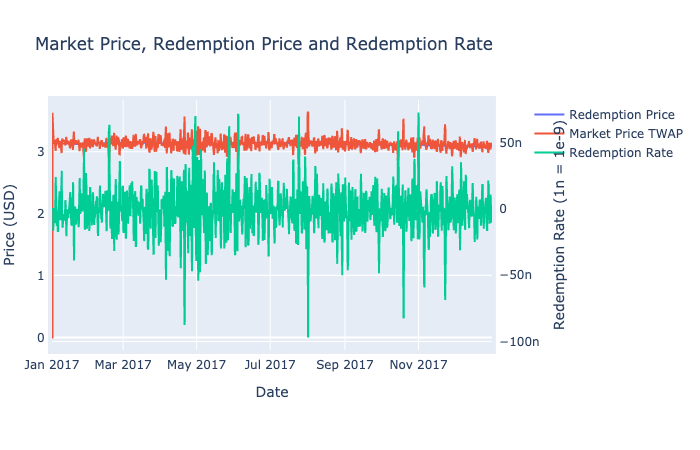

In [29]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Redemption Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price_twap'], name="Market Price TWAP"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_rate'], name="Redemption Rate"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Market Price, Redemption Price and Redemption Rate"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Redemption Rate (1n = 1e-9)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

## Simulation statistics

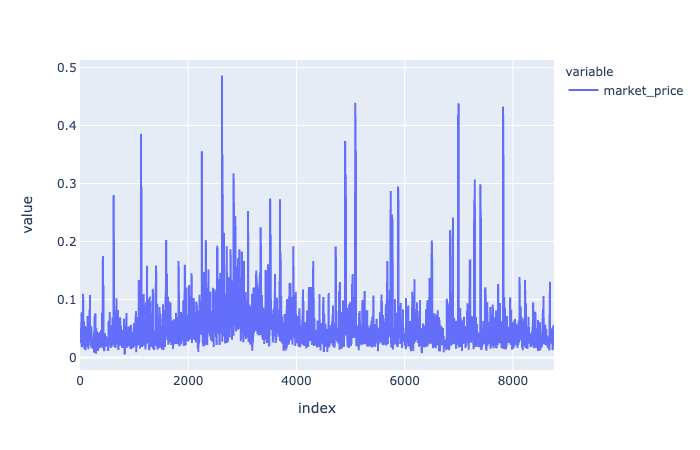

In [30]:
std_mkt = df['market_price'].rolling(7).std()
std_mkt.plot()

In [31]:
np.std(df['market_price'])

0.12143150971409504

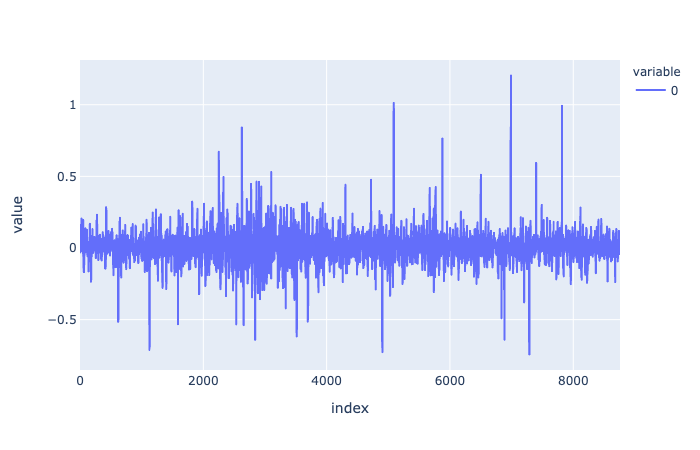

In [32]:
err_m_t = df['market_price'] - df['target_price']
err_m_t.plot()

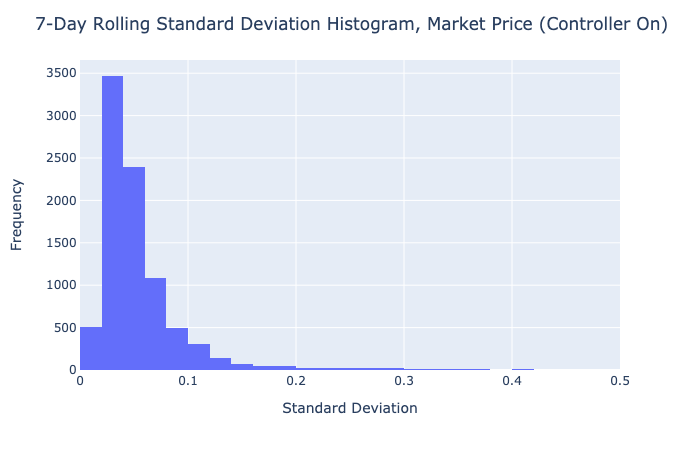

In [33]:

df['market_price_rolling'] = df['market_price'].rolling(7).std()
fig = px.histogram(df, x="market_price_rolling", nbins=25)

fig.update_layout(
    title="7-Day Rolling Standard Deviation Histogram, Market Price (Controller On)",
    xaxis_title="Standard Deviation",
    yaxis_title="Frequency",
)

fig.show()